In [1]:
#https://youtu.be/6S2v7G-OupA
"""
@author: Sreenivas Bhattiprolu

Shows errors on Tensorflow 1.4 and Keras 2.0.8

Works fine in Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


Start date is:  2020-01-02 00:00:00
End date is:  2024-12-31 00:00:00


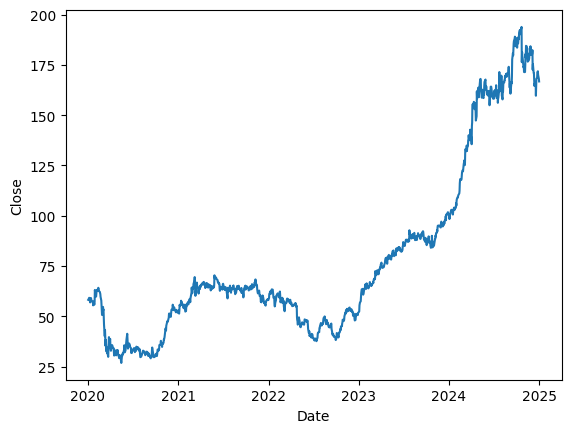

In [11]:

# Load the dataset and skip the first two rows
dataframe = pd.read_csv('GE.csv', skiprows=2)
dataframe = dataframe.rename(columns={"Unnamed: 1": "Close"})

data = dataframe[['Date', 'Close']]

data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

sns.lineplot(x=data['Date'], y=data['Close'])

print("Start date is: ", data['Date'].min())
print("End date is: ", data['Date'].max())

In [12]:
print(data.columns)

Index(['Date', 'Close'], dtype='object')


In [13]:
print(data.head())

                  Date      Close
0  2020-01-02 00:00:00  58.161148
1  2020-01-03 00:00:00  58.356167
2  2020-01-06 00:00:00  59.184959
3  2020-01-07 00:00:00  58.746178
4  2020-01-08 00:00:00  58.209915


In [14]:
# Check the shape of the DataFrame
print(data.shape)

(1258, 2)


In [17]:
# Feature engineering
data.loc[:, 'Returns'] = data['Close'].pct_change()
data.loc[:, 'Volatility'] = data['Returns'].rolling(window=5).std()
data.loc[:, 'MA_10'] = data['Close'].rolling(window=10).mean()
data.dropna(inplace=True)

C:\Users\mohm2\AppData\Local\Temp\ipykernel_30788\3162540281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [69]:
# Label the data (1 = anomaly, 0 = no anomaly)
data.loc[:, 'Anomaly'] = ((data['Close']) > data['MA_10'] + 500 * data['Volatility']).astype(int)
data.loc[:, 'Anomaly'] = data['Anomaly'].shift(-1)  # Shift labels forward
data.dropna(inplace=True)

C:\Users\mohm2\AppData\Local\Temp\ipykernel_30788\536145782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


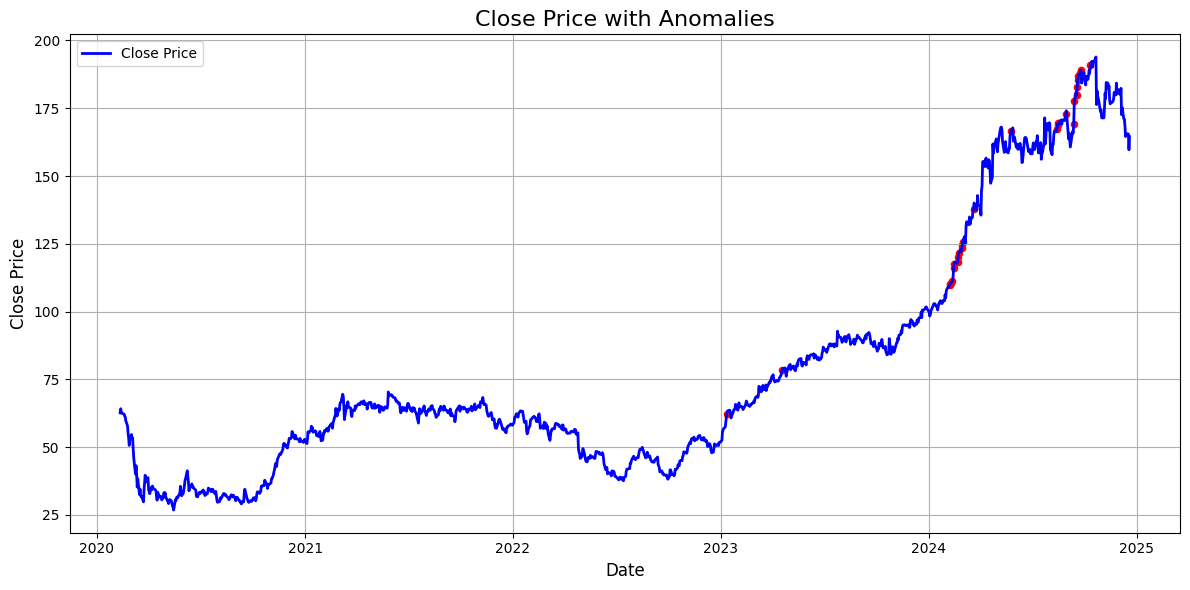

In [70]:
# Create the plot
plt.figure(figsize=(12, 6))

# Line plot for Close Price
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue', linewidth=2)

# Scatter plot for anomalies
for i, anomaly in enumerate(data['Anomaly']):
    if anomaly == 1:
        plt.scatter(data['Date'].iloc[i], data['Close'].iloc[i], color='red', label='Anomaly' if i == 0 else "", s=20)

# Adding labels and legend
plt.title('Close Price with Anomalies', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [71]:
anomaly_percentage = data['Anomaly'].mean() * 100
print(f"Anomalies constitute {anomaly_percentage:.2f}% of the dataset.")

Anomalies constitute 2.37% of the dataset.


In [21]:
print(data.head())

                   Date      Close   Returns  Volatility      MA_10  Anomaly
27  2020-02-11 00:00:00  62.646355 -0.004648    0.012223  62.090571      1.0
28  2020-02-12 00:00:00  64.157646  0.024124    0.012917  62.197825      1.0
29  2020-02-13 00:00:00  63.085106 -0.016717    0.015873  62.300203      1.0
30  2020-02-14 00:00:00  62.548832 -0.008501    0.015765  62.485461      0.0
31  2020-02-18 00:00:00  62.158825 -0.006235    0.015536  62.724345      0.0


In [72]:
# Separate features and labels
features = data[['Close', 'Returns', 'Volatility', 'MA_10']]
labels = data['Anomaly'].values  # Keep labels as-is

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [34]:
print(scaled_features)

[[-0.35822365 -0.23260142 -0.61798191 -0.36521303]
 [-0.32384088  0.92829942 -0.56786311 -0.36275128]
 [-0.3482418  -0.71959537 -0.35431625 -0.36040144]
 ...
 [ 2.11168781  0.54456099  0.34600253  2.02434729]
 [ 2.12667863  0.11020781 -0.67127987  2.03239052]
 [ 2.08595523 -0.46530018 -0.6194597   2.04505597]]


In [62]:
# Combine scaled features and labels
scaled_data = np.hstack((scaled_features, labels.reshape(-1, 1)))  # Add labels as the last column

In [36]:
print(scaled_data)

[[-0.35822365 -0.23260142 -0.61798191 -0.36521303  1.        ]
 [-0.32384088  0.92829942 -0.56786311 -0.36275128  1.        ]
 [-0.3482418  -0.71959537 -0.35431625 -0.36040144  1.        ]
 ...
 [ 2.11168781  0.54456099  0.34600253  2.02434729  1.        ]
 [ 2.12667863  0.11020781 -0.67127987  2.03239052  1.        ]
 [ 2.08595523 -0.46530018 -0.6194597   2.04505597  1.        ]]


In [63]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # All columns except the last (features)
        y.append(data[i+seq_length, -1])    # Only the last column (label)
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [64]:
y

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [66]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           68096     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 117,569
Trainable params: 117,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
27/27 [==============================] 

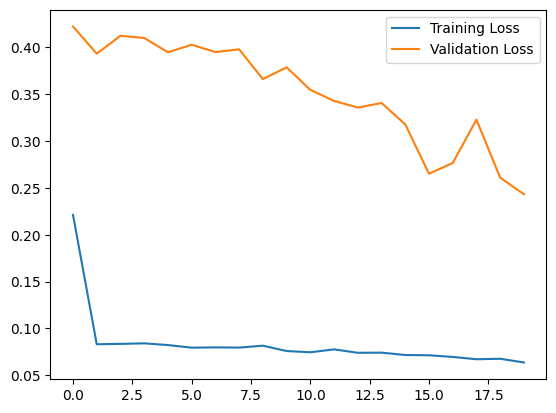

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

8/8 [==============================] - 2s 31ms/step - loss: 1.3890 - accuracy: 0.2803
Test Accuracy: 0.2803347408771515
8/8 [==============================] - 2s 35ms/step


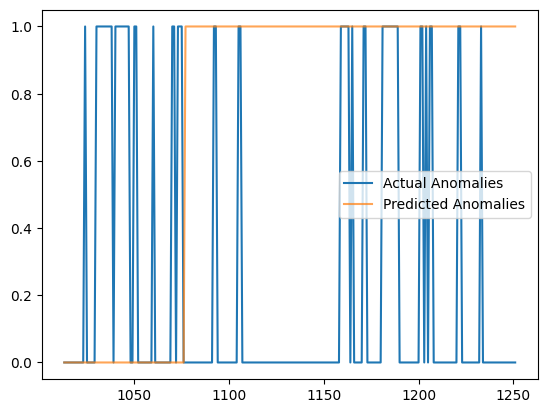

In [67]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict anomalies
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Plot results
import matplotlib.pyplot as plt

plt.plot(data.index[-len(y_test):], y_test, label='Actual Anomalies')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Anomalies', alpha=0.7)
plt.legend()
plt.show()